# Portfolio assignment week 7

## 1. Bagging vs Boosting
The scikit-learn library provides several options for bagging and boosting. It is possible to create your own boosting model based on a base model. For instance, you can create a tree based bagging model. In addition, scikit-learn provides AdaBoost. For XGBoost it is best to use the xgboost library.

Based on the theory in the [accompanying notebook](../Exercises/E_BAGGING_BOOSTING.ipynb), create a bagging, boosting and dummy classifier. Test these classifiers on the [breast cancer dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). Go through the data science pipeline as you've done before:

1. Try to understand the dataset globally.
2. Load the data.
3. Exploratory analysis
4. Preprocess data (skewness, normality, etc.)
5. Modeling (cross-validation and training). (**Create several bagging classifiers with different estimators**.)
6. Evaluation (**Use the evaluation methods as described in the previous lessons. Then compare the different models**.)
7. Try to understand why some methods perform better than others. Try different configurations for your bagging and boosting models.

# Dataset
While I should admit that using the same dataset twice is not fun at all, the outcome of the privious Assignment (Assignment6) urges to use the Titanic dataset again for this assignment. The reason is that the model generated through the Decision Tree approach did not exhibit satisfactory accuracy, achieving only 80% accuracy in label predictions.Consequently, I am inclined to explore the application of a meta-model to the dataset. The aim is to potentially yield improved outcomes—a more suitable model—for accurately predicting the labels.

Consequently, in this assignment I will use The <a href="https://www.kaggle.com/datasets/vinicius150987/titanic3?resource=download" target="_blank">Titanic</a> dataset again and try to improve the predictiong power by using different meta models. For more information about this dataset one can delve into details of the privious assignment.

# Data Loading
First, I import the relavant libraries.

In [80]:
# General Modules
import yaml
import math
import os
import graphviz
import time
import re
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from joblib import dump, load

# Data generating and feature modules
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles

# preprocessing modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Classification modules
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.dummy import DummyClassifier
from sklearn import tree

# meta-Model modules
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

In [3]:
def dataframe_maker(config):
    file_directory, file_name_titanic = config.values()
    os.chdir(file_directory)
    df_titanic = pd.read_excel(file_name_titanic)
    return df_titanic
df_titanic = dataframe_maker(configReader())
df = df_titanic
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


I explored and inspect this dataset in the privious Assignment, so in this assignment I will just use some of the inspection functions and move forward to the Data Cleaning and Preprocessing. For more information about this dataset one can have a look at 'Assignment6'.

This dataset consists of 1309 samples (passengers) and 14 features. Although each feature has the potential to influence the model's outcome, some of them may not significantly impact the model's functionality. Therefore, understanding the nature of each feature becomes crucial for the subsequent steps in the data-science pipeline. This knowledge empowers researchers to discern whether a feature holds importance in the analysis.  Thus, all the features will be described in the following paragraphs.

1. **pclass**: presents ticket classes, a potentially significant feature that could have influenced the chances of survival. It is plausible that individuals from higher classes had a better chance of surviving, making this feature relevant for the analysis.

2. **survived**: shows the labels that whether a passenger lost his/her life or survived from this disastorous event.

3. **name**: contains the names of the passengers.

4. **sex**: includes the gender of the passengers, which can significantly influence the model's performance. During emergency conditions, women are often prioritized for protection, making this feature highly relevant and potentially impactful on the model's predictions.

5. **age**: This variable represents the age of the passengers, and once again, it can significantly impact the model's outcome. During emergency conditions, children are often given priority for protection, making this feature particularly relevant for predicting survival rates.

6. **sibsp**: is the number of siblings and spouse. It can have a slight effect on the outcome of the model. Maybe people with higher number of sibsp had less chance of surviving.

7. **parch**: this number preents the number of parents and children. This parameter is quite similar to privious one (sibsp).

8. **ticket**: contains the number of passengers' tickets. It seems irrelevant to the topic.

9. **fare**: includes the price of the tickets, which can be useful for classifying passengers based on their socio-economic status. Higher ticket prices might indicate a higher social class, while lower prices might correspond to a lower class. This feature can be valuable in categorizing passengers according to their economic standing.

10. **cabin**: consists of information about the numbers of cabins for which passengers paid. This feature could be significant as passengers from cabins near the deck might have had an advantage, reaching the surface of the ship more quickly, which could have increased their chances of survival.

11. **embarked**: includes the ports in which passengers are get into the ship.

12. **boat**: consists of the boats' codes with which some of the passengers survived.

13. **body**: contains the body numbers if did not survive and body was recovered. <a href="https://github.com/awesomedata/awesome-public-datasets/issues/351" target="_blank">link</a> 

14. **home.dest**: contains the home destination of all the the passengers.

# Data inspection
The most important part of data analyzing pipeline. 

In [4]:
def data_inspecter(df):
    # find the shape of data
    print(f'dataset has {df.shape[0]} observations, and {df.shape[1]} variables\n')

    # finding the information of this dataset
    print(f'{df.info()}\n')

    # extract the number of null values of the dataset
    null_values = df.isnull().sum().sum()
    print(f'the total number of null values in this dataset is {null_values}\n')

    # Find the unique values of different categorical variables
    class_values = list(df.pclass.unique())
    print(f'number of unique groups in pclass is {len(class_values)}\ngroups are:{class_values}\n')

    gender_values = list(df.sex.unique())
    print(f'number of unique groups in sex-var is {len(gender_values)}\ngroups are:{gender_values}\n')

    sibsp_values = list(df.sibsp.unique())
    print(f'number of unique groups in sibsp-var is {len(sibsp_values)}\ngroups are:{sibsp_values}\n')

    parch_values = list(df.parch.unique())
    print(f'number of unique groups in parch-var is {len(parch_values)}\ngroups are:{parch_values}\n')

    embark_values = list(df.embarked.unique())
    print(f'number of unique groups in embarked-var is {len(embark_values)}\ngroups are: {embark_values}\n')

    # Find the mean, max and min value of the age colmun
    print(f'The youngest passenger had {df.age.min()} years old\n')
    print(f'The oldest passenger had {df.age.max()} years old\n')
    print(f'The mean age of the passengers is: {round(df.age.mean(), 3)} years old\n')

    # Find the mean, max and min value of the tickets
    print(f'The cheapest ticket costs {df.fare.min()}\n')
    print(f'The most expensive ticket costs {df.fare.max()}\n')
    print(f'The average cost of the tickets is: {round(df.fare.mean(), 3)}\n')
    print(f'the number of passengers who paid the minimum price for the ticket is {pd.DataFrame(df[df.fare == 0.0]).shape[0]}')

data_inspecter(df)

dataset has 1309 observations, and 14 variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB
None

the total number of null values in this dataset is 3855

number of unique groups in pclass is 3
groups are:[1, 2, 3]

number of unique

For more information about this dataset, one can delve into Assignment6.

# Data Cleaning and Preprocessing
This section introduces some changes compared to the previous assignment. I will create two separate datasets based on the original data. For the first dataset, I will apply a similar cleaning process as I did in Assignment 6. However, for the second dataset, I will retain certain columns that were excluded from the first dataset due to a significant number of missing values. The reason behind this decision is that certain advanced techniques, such as the Random Forest algorithm, are capable of handling datasets with a substantial amount of missing data. By including these columns, I can take advantage of their potential for better model performance.

Moreover, an additional motivation for crafting a dataset similar to the preceding assignment emerges from the establishment of a baseline for comparing outcomes between crafted models using meta-models and a basic Decision Tree. Additionally, the second dataset can serve as a means to compare results obtained through alterations made to the datasets.

To sum up, I am creating two distinct datasets: one tailored for methods that struggle with missing data and another designed to leverage the strengths of meta models that can effectively handle such challenges.

**First Dataset**

Some hanges will be implemented in this dataset.

1. Dropping the redundant columns ('name', 'ticket', 'cabin', 'embarked', 'boat', 'body', 'home.dest').

2. Summing and merging 'sibsp' and 'parch' columns.

3. Filling missing values of 'age' and 'fare' columns.

4. Convert 'sex' column label to '0' for 'male' and '1' for 'female'. The reason is that the Decision Tree algorithm cannot convert string to numbers.

In [5]:
def df_preprocessor_first(df):
    corrected_df = df.copy()

    # drop the irrelevant columns
    corrected_df = corrected_df.iloc[:,:9].drop(columns=['name', 'ticket'])

    # merge  'parch' and 'sibsp'
    corrected_df.sibsp = corrected_df.loc[:,['sibsp', 'parch']].sum(axis=1)
    corrected_df = corrected_df.rename(columns={'sibsp':'family'}).drop(columns=['parch'])

    # Fill missing values of 'age' column with mean value
    corrected_df.age = corrected_df.age.fillna(value=corrected_df.age.mean())

    # Fill the missing value of 'fare' column with mean value
    corrected_df.fare = corrected_df.fare.fillna(value=corrected_df.fare.mean())

    # Convert 'sex' columns to '0' = male, '1' = 'female'
    corrected_df.sex = corrected_df.sex.replace(['male','female'],[0, 1])
    return corrected_df

first_df = df_preprocessor_first(df)
first_df.head()

,pclass,survived,sex,age,family,fare
0,1,1,1,29.0000,0,211.3375
1,1,1,0,0.9167,3,151.5500
2,1,0,1,2.0000,3,151.5500
3,1,0,0,30.0000,3,151.5500
4,1,0,1,25.0000,3,151.5500


**Second Dataset**

Certain modifications made in the first dataset will also be incorporated into the second one. Nonetheless, two specific alterations will not be carried over. Primarily, the columns 'boat,' 'cabin,' and 'body' will be retained within the dataset. Secondly, the columns 'parch' and 'sibsp' will not be merged together. While these changes persist, additional adjustments will be applied to the dataset to facilitate its preparation for more in-depth analysis.

In [6]:
def df_preprocessor_second(df):    
    corrected_df = df.copy()

    # drop the irrelevant columns
    corrected_df = corrected_df.iloc[:,:-1].drop(columns=['name', 'ticket', 'embarked'])

    # Fill missing values of 'age' column with mean value
    corrected_df.age = corrected_df.age.fillna(value=corrected_df.age.mean())

    # Fill the missing value of 'fare' column with mean value
    corrected_df.fare = corrected_df.fare.fillna(value=corrected_df.fare.mean())

    # Convert 'sex' columns to '0' = male, '1' = 'female'
    corrected_df.sex = corrected_df.sex.replace(['male','female'],[0, 1])

    # I will use replace to change the values in cabin, boat column since dummies is not working here
    corrected_df.cabin.replace(set(corrected_df.cabin),
                        np.arange(0, len(set(corrected_df.cabin))), inplace=True)
    corrected_df.boat.replace(set(corrected_df.boat),
                        np.arange(0, len(set(corrected_df.boat))), inplace=True)
    corrected_df.body.replace(set(corrected_df.body),
                        np.arange(0, len(set(corrected_df.body))), inplace=True)
    return corrected_df

second_df = df_preprocessor_second(df)
second_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,boat,body
0,1,1,1,29.0000,0,0,211.3375,84,1,1308.0
1,1,1,0,0.9167,1,2,151.5500,23,13,1308.0
2,1,0,1,2.0000,1,2,151.5500,23,0,1308.0
3,1,0,0,30.0000,1,2,151.5500,23,0,76.0
4,1,0,1,25.0000,1,2,151.5500,23,0,1308.0


Now one can implement different different meta-models to these dataset and tune their parameters. In the following section, I will first analyze the first dataset, and the move forward to analyze the second dataset.

# Implementation of Meta Models on the First Dataset
In the previous assignment, the Decision Tree algorithm managed to attain an accuracy of approximately 80% when classifying this dataset. As a result, in this section, I will explore various meta models, employing accuracy as the evaluation criterion, to establish a foundational benchmark for subsequent comparisons.

But first, I partition the dataset into separate training and testing sets. It's worth noting that when dealing with a sufficiently large dataset, this division into distinct training and testing subsets is undertaken without encountering the challenge of variance-bias trade-off.

In [53]:
# Make X and y
X_first = first_df.drop(columns=['survived'])
y_first = first_df.survived

# Divide the data set into training and testing dataset.
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_first, y_first, test_size=0.15)

print(f'training dataset has the following shape: {X_train1.shape}')
print(f'testing dataset has the following shape: {X_test1.shape}')

training dataset has the following shape: (1112, 5)
testing dataset has the following shape: (197, 5)


The training dataset contains 1112 datapoints, and the testing dataset contains 197 datapoints.

Regarding Implementing meta-models, I will use 'multiple_gridsearch_ensembel' function that can cover tuning of the base estimator and the meta models simultaniously. I will use Bagging, Adaptive Boosting, Gradient Boosting and also Stacking model, and then compare the performance of them by predicting the label of the testing dataset.

In [8]:
def multiple_gridsearch_ensembel(estimator_dict,scoring_list, cv_number, refit_method, data_dict):

    final_dict = {}

    for name in estimator_dict.keys():
        
        if len(estimator_dict[name][2].keys()) != 0:
            estimator_params = estimator_dict[name][2]
            best_estimator_dict = {}
            counter = 0            

            for estimator in estimator_params.keys():

                
                # make different combination of parameters
                param_combinations = product(*[v for k, v in estimator_params[estimator].items()])
                params_names = list(estimator_params[estimator].keys())
        
                for params in param_combinations:
                    start = time.time()
                    eval_arguments = ', '.join(f'{params_names[i]}={params[i]}' for i in range(len(params_names)))
                    eval_statement = (
                    f"{estimator}({eval_arguments})"
                    )
                    
                    model_estimator = eval(eval_statement)           
                    estimator_dict[name][1]['estimator'] = [model_estimator]

                    # Create the GridSearchCV object
                    grid_search = GridSearchCV(estimator=estimator_dict[name][0], param_grid=estimator_dict[name][1],
                                        scoring=scoring_list, cv=cv_number, refit=refit_method)

                    grid_search.fit(data_dict['x'], data_dict['y'])

                    # Save the best estimator for each model
                    best_estimator_dict[counter] = {'best_model': grid_search.best_estimator_,
                                                    'best_parameters': grid_search.best_params_,
                                                    'best_score': grid_search.best_score_}
    
                    counter += 1
                end = time.time()
                print(f'time: {end-start}')

            # find the best model in terms of oob_score
            best_model_number = max(best_estimator_dict, key=lambda k: best_estimator_dict[k]['best_score'])

            # Save the best estimator for each model
            final_dict[name] = best_estimator_dict[best_model_number]

        else:
            # Create the GridSearchCV object
            grid_search = GridSearchCV(estimator=estimator_dict[name][0], param_grid=estimator_dict[name][1],
                                            scoring=scoring_list, cv=cv_number, refit=refit_method)
                
            # Fit the the best model to the data
            grid_search.fit(data_dict['x'], data_dict['y'])

            # Save the best estimator for each model
            final_dict[name] = {'best_model': grid_search.best_estimator_,
                                'best_parameters': grid_search.best_params_,
                                'best_score': grid_search.best_score_}

        # order the dictionary based on the magnitude of the scores
        final_dict = dict(sorted(final_dict.items(), key=lambda item: -1 * item[1]['best_score']))
            
    return final_dict

In [ ]:
# make parameters dictionaries

# Base estimator parameters bagging
estimator_params_bagging = {'SVC' : {'C': np.arange(0.01, 1.1, 0.25),
                                     'degree': np.arange(2,10,2)},

                            'LogisticRegression': {'C':  np.arange(0.01, 10, 0.25)},

                            'tree.DecisionTreeClassifier': {'max_depth': [None, 5, 10],
                                                            'min_samples_split': [2, 5],
                                                            'min_samples_leaf': [1, 2],
                                                            'min_impurity_decrease': [0, 1],}}

# Base estimator parameters adaptive boosting
estimator_params_ada =  {'LogisticRegression': {'C':  np.arange(0.01, 10, 0.25)},
                         'tree.DecisionTreeClassifier': {'max_depth': [None, 5, 10],
                                                         'min_samples_split': [2, 5],
                                                         'min_samples_leaf': [1, 2],
                                                         'min_impurity_decrease': [0, 1],}}
# BaggingClassifier
bagging_param = {'estimator': [SVC(), LogisticRegression(), tree.DecisionTreeClassifier()],
                 'n_estimators': np.arange(10,20,2),
                 'max_samples': np.arange(350,650,100),
                 'max_features': np.arange(5,10,1),
                 'bootstrap': [False, True],
                 'bootstrap_features': [False, True],
                 'n_jobs': [-1]
                }


# RandomForest Classifier
rf_param = {
    'n_estimators': np.arange(20, 200, 20),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_impurity_decrease': [0, 0.05, 0.1],
    'max_samples': [None, 0.05,0.1,0.2],
    'n_jobs': [-1]
}

# AdaptiveBoosting Classifier
ada_param = {'estimator': [LogisticRegression(), tree.DecisionTreeClassifier()],
                 'n_estimators': np.arange(25, 100, 25)}

# GradientBoosting Classifier
grad_param = {'learning_rate' : [0.0, 0.5, 1, 10],
    'n_estimators': np.arange(20, 200, 20),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_impurity_decrease': [0, 0.05, 0.1],
    'max_features' : ['sqrt', 'log2']
}

# Scoring list
scoring_list = ['roc_auc', 'f1', 'accuracy']

# Make estimator dictionary
estimator_dict={'BaggingClassifier': [BaggingClassifier(), bagging_param, estimator_params_bagging],
                'RandomForest': [RandomForestClassifier(), rf_param, {}],
                'AdaBoostClassifier': [AdaBoostClassifier(), ada_param, estimator_params_ada],
                'GradBoostClassifier': [GradientBoostingClassifier(), grad_param, {}],
                }

# Make data dictionary
data_dict =  {'x': X_train1, 
              'y': y_train1}

best_models_dict1 = multiple_gridsearch_ensembel(estimator_dict, scoring_list, 10, 'accuracy', data_dict)

The process of training the above model is quite time consuming. Consequently, the best way to use these model in further studies is to save them in a definite directory, and use them for later investigation.

In [25]:
def save_read_model(directory, action, model_dict=None):    
    os.chdir(directory)

    if action == 'write':

        try:
            for name in model_dict.keys():
                dump(model_dict[name]['best_model'], f'{name}.joblib')
        except TypeError:
                dump(model_dict['best_model'], f'{name}.joblib')

    elif action == 'read':
        # List all files in the directory
        file_list = os.listdir(directory)

        # Filter the list to include only .joblib files
        joblib_files = [file for file in file_list if file.endswith('.joblib')]

        # Load models and create a dictionary
        models_dict = {}

        for file in joblib_files:
            # Extract filename without extension
            model_name = os.path.splitext(file)
            model_path = os.path.join(directory, file)
            model = load(model_path)
            models_dict[model_name[0]] = model

        return models_dict

In [ ]:
# Save the models
path ='D:/Data Science for Life Science/Machine Learning and Deep learning/Data/Data_week6'
models_dict = save_read_model(path, 'write', model_dict=None)

In [54]:
# load the models
path ='D:/Data Science for Life Science/Machine Learning and Deep learning/Data/Data_week6'
models_dict = save_read_model(path, 'read', model_dict=None)

In [55]:
models_dict

{'AdaBoostClassifier': AdaBoostClassifier(estimator=LogisticRegression(C=0.76), n_estimators=75),
 'BaggingClassifier': BaggingClassifier(bootstrap=False,
                   estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_impurity_decrease=0,
                                                    min_samples_split=5),
                   max_features=5, max_samples=350, n_estimators=14, n_jobs=-1),
 'GradBoostClassifier': GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features='sqrt',
                            min_impurity_decrease=0.1, min_samples_split=10,
                            n_estimators=20),
 'RandomForest': RandomForestClassifier(max_samples=0.2, min_impurity_decrease=0,
                        n_estimators=60, n_jobs=-1),
 'StackingClassifier': StackingClassifier(cv=10,
                    estimators=[('RandomForest',
                                 RandomForestClassifier(criterion='entropy',
          

Consequently, one can save and reuse any model by using the above function. I always train my models at night since it can be a quite consuming task, so one can write the code and test it for any possible error, then run it during sleep time. Moreover one can use stacking model for this dataset.


In [12]:
def multiple_grid_search(estimator_dict, scoring_list, cv_number, refit_method, data_dict):

    final_dict = {}

    for name in estimator_dict.keys():
        
        # Create the GridSearchCV object
        grid_search = GridSearchCV(estimator=estimator_dict[name][0], param_grid=estimator_dict[name][1],
                                    scoring=scoring_list, cv=cv_number, refit=refit_method)
        
        # Fit the the best model to the data
        grid_search.fit(data_dict['x'], data_dict['y'])

        # Save the best estimator for each model
        final_dict[name] = {'best_model': grid_search.best_estimator_,
                            'best_parameters': grid_search.best_params_,
                            'best_score': grid_search.best_score_}

    # order the dictionary based on the magnitude of the scores
    final_dict = dict(sorted(final_dict.items(), key=lambda item: -1 * item[1]['best_score']))
     
    return final_dict

In [13]:
def stacking_meta_model(estimator_dict, scoring_list, cv_number, refit_method, data_dict, final_est_list):

    start = time.time()
    final_dict = multiple_grid_search(estimator_dict, scoring_list, cv_number, refit_method, data_dict)
    end = time.time()
    print (f'base estimators tunning time is: {end - start}')

    estimators_list = [(model, final_dict[model]['best_model']) for model in final_dict.keys()]
    #print(estimators_list)
    start = time.time()

    for estimator in final_est_list:
        
        # Create the GridSearchCV object
        clf = StackingClassifier(estimators=estimators_list, final_estimator=estimator,
                                 cv=cv_number, n_jobs=-1)

        # Fit the the best model to the data
        clf.fit(data_dict['x'], data_dict['y'])

        # Save the best estimator for each model
        final_dict[estimator] = {'best_model': clf,
                                 'parameters': {'base_estimators': final_dict,
                                                'final_estimator': estimator},
                                 'score': clf.score(data_dict['x'], data_dict['y'])}
    end = time.time()
    print(final_dict[estimator]['score'])
    print (f'model tunning time is: {end - start}')

    # order the dictionary based on the magnitude of the scores
    model_dict = dict(sorted(final_dict.items(), key=lambda item: -1 * item[1].get('score', 0)))
    best_model = model_dict[list(model_dict.keys())[0]]
    return best_model

In [ ]:
# make parameters dictionaries
# SVC
# one can use all of these parameters, but due to my laptop's power, 
# I will limit it into a couple of parameters
svc_param = {'C': [0.1, 0.5, 1],
    'kernel': ['poly', 'rbf', 'linear', 'sigmoid'],
    'degree': [2, 3, 4],  # Only for 'poly' kernel
    'SVC__gamma': ['scale', 'auto', 0.1, 1, 10],  # 'scale' and 'auto' are for 'rbf' and 'poly' kernels
    'coef0': [0, 0.1, 0.5],  # Only for 'poly' and 'sigmoid' kernels
    'tol': [1e-3, 1e-4, 1e-5], 
    }

# Create a pipeline with StandardScaler and SVC
svc_pipeline = Pipeline([('StandardScaler', StandardScaler()),
                                         ('SVC', SVC())])

# Make estimator dictionary
estimator_dict = {'RandomForest': [RandomForestClassifier(), rf_param],
                  'SVC': [SVC(), svc_param]}

# Make data dictionary
data_dict =  {'x': X_train1, 
              'y': y_train1}

# Make a list of final estimators
final_est_list = [LogisticRegression(), SVC()]

best_model_stacking1 = stacking_meta_model(estimator_dict, scoring_list, 10, 'accuracy', data_dict, final_est_list)

Now in the following section I will investigate the prediction ability of these models, and evaluate which one actually outperforms the others.

## Evaluation section
In this section, I will use the following functions to evaluate the performance of all the models.

In [56]:
def f_score(y_actual, y_predict):

    precision = precision_score(y_actual, y_predict)
    recall = recall_score(y_actual, y_predict)

    f_score = (2.0 * precision * recall) / (precision + recall)

    return f_score

def precision(y_actual, y_predict):
    return precision_score(y_actual, y_predict)

def recall(y_actual, y_predict):
    return recall_score(y_actual, y_predict)

def confusion(y_actual, y_predict):
    return confusion_matrix(y_actual, y_predict)

def accuracy(y_actual, y_predict):

    cm = confusion_matrix(y_actual, y_predict)

    acc = (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])

    return acc

def auc_roc(y_actual, y_predict):
    fp, tp, threshold = roc_curve(y_actual, y_predict)
    area = auc(fp, tp)

    auc_roc_dict = {
                    'false_positive': fp,
                    'true_positive': tp,
                    'threshold': threshold,
                    'auc': area
                    }
    return auc_roc_dict

def evaluation_presentor(evaluation_list, y_actual, y_pred):

    for metric in evaluation_list:
        metric_value = eval(metric)(y_actual, y_pred)
        print(f'{metric}: {round(metric_value, 3)}')

def model_evaluation(model_dict, x_test, y_test, evaluation_list):
    for model in model_dict:
        print(f'\n{model}')
        y_pred = model_dict[model].predict(x_test)
        evaluation_presentor(evaluation_list, y_test, y_pred)

In [48]:
# Make evaluation list
evaluation_list = ['accuracy', 'precision', 'f_score', 'recall']

# investigating evaluation metrics
evaluation_dict = model_evaluation(models_dict, X_test1, y_test1, evaluation_list)


AdaBoostClassifier
accuracy: 0.797


precision: 0.769
f_score: 0.714
recall: 0.667

BaggingClassifier
accuracy: 0.848
precision: 0.857
f_score: 0.783
recall: 0.72

GradBoostClassifier
accuracy: 0.843
precision: 0.879
f_score: 0.767
recall: 0.68

RandomForest
accuracy: 0.838
precision: 0.852
f_score: 0.765
recall: 0.693

StackingClassifier
accuracy: 0.817
precision: 0.842
f_score: 0.727
recall: 0.64


Almost all of the ensemble methods shows the same prediction power. However, Bagging classifier is slighty more accurate Among all of the ensemble methods, it shows a better recall and f_score. Moreover, one can plot the confusion metrics that can give use a better understanding of the performance these models.

In [98]:
def cm_plotter(models_dict, X_test, y_test, logarithm=False):
    cm_dict = {}
    for model in models_dict:
        y_predict = models_dict[model].predict(X_test)
        cm = confusion(y_test, y_predict)
        cm_dict[model] = cm

    plot_numbers = len(models_dict.keys())
    num_cols= math.ceil(math.sqrt(plot_numbers))
    num_rows = math.ceil(plot_numbers / num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten()
    for i, ax in enumerate(axes):

        try:
            cm = cm_dict[list(cm_dict.keys())[i]]

            if logarithm:
                cm = np.log(cm)

            sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
            ax.set(aspect='equal',
                xlabel='Predicted Labels',
                ylabel='$True Labels$')
            ax.set_title(f'{list(cm_dict.keys())[i]}')
        except:
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

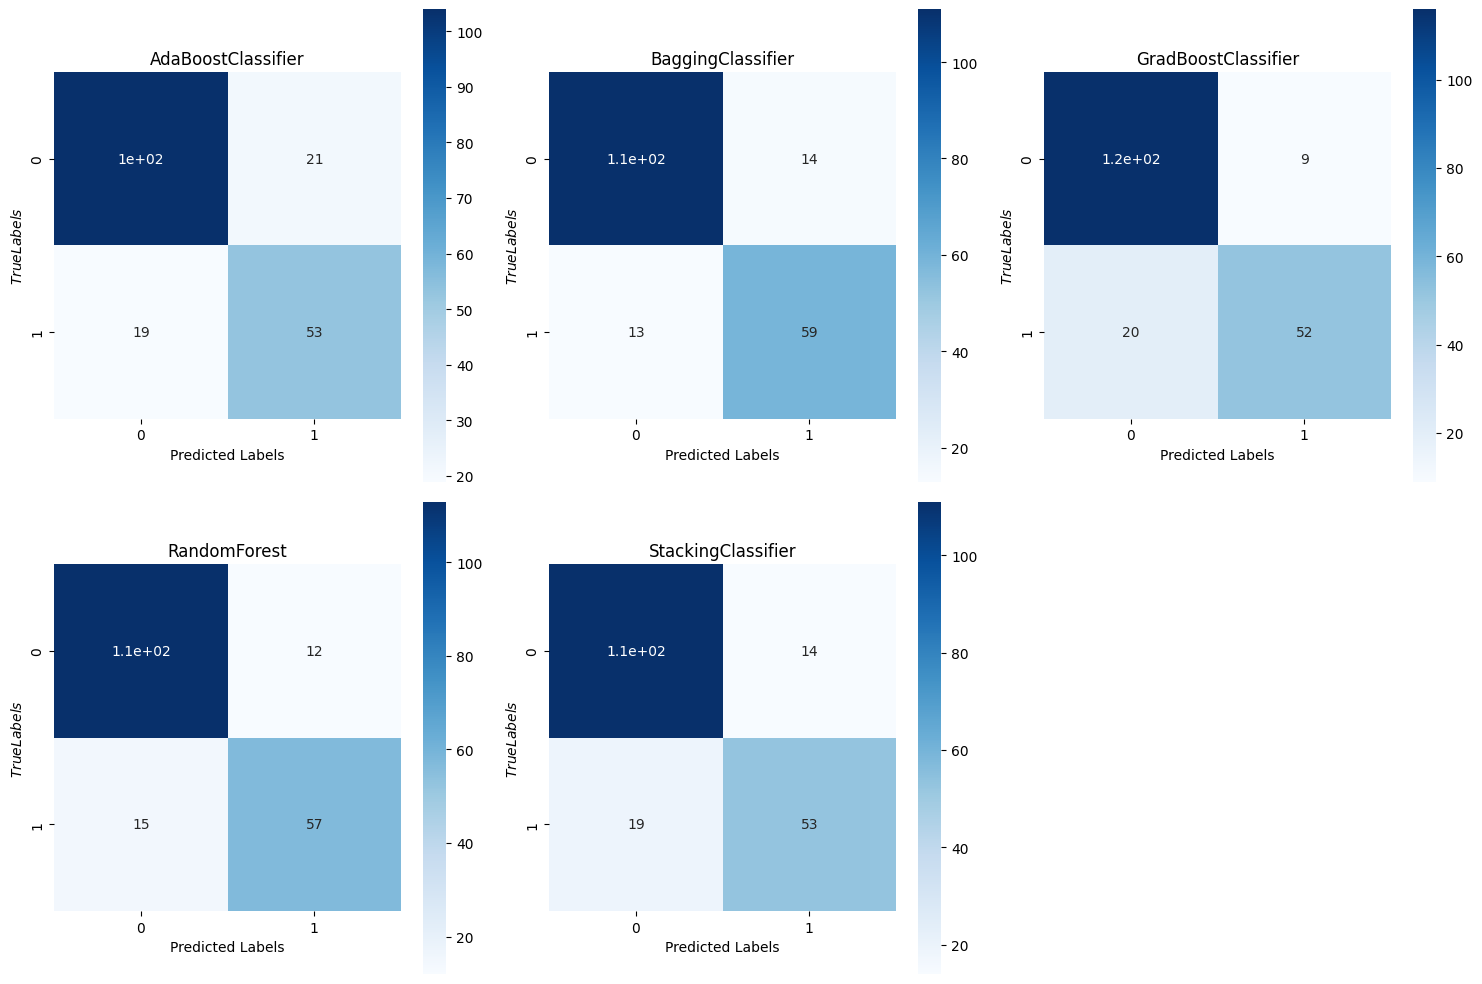

In [99]:
evaluation_dict = cm_plotter(models_dict, X_test1, y_test1,)

Again, one can see that Bagging Classifier shows a better performance. Also, random forest has almost the same good performance.

To continue, one can use the second preprocessing, and implement meta models on the second dataset.

# Implementation of Meta Models on the Second Dataset
For this dataset I only choose to train Random Forest and Gradient Boosting model, try to evaluate their performance, and compare the outcome with the privious version of the dataset.

In [100]:
# Make X and y
X_second = second_df.drop(columns=['survived'])
y_second = second_df.survived

# Divide the data set into training and testing dataset.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_second, y_second, test_size=0.15)

print(f'training dataset has the following shape: {X_train2.shape}')
print(f'testing dataset has the following shape: {X_test2.shape}')

training dataset has the following shape: (1112, 9)
testing dataset has the following shape: (197, 9)


In [101]:
rf_param = {
    'n_estimators': np.arange(100, 200, 100),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_impurity_decrease': [0, 0.05],
    'max_samples': [None, 0.05],
    'n_jobs': [-1]
}
grad_param = {'learning_rate' : [0.0, 0.5, 1],
    'n_estimators': np.arange(100, 200, 100),
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_impurity_decrease': [0, 0.05],
}
# Make estimator dictionary
estimator_dict={
                'RandomForest': [RandomForestClassifier(), rf_param, {}],
                'GradBoostClassifier': [GradientBoostingClassifier(), grad_param, {}],
                }
# Scoring list
scoring_list = ['roc_auc', 'f1', 'accuracy']
# Make data dictionary
data_dict =  {'x': X_train2, 
              'y': y_train2}

best_model_dict2 = multiple_gridsearch_ensembel(estimator_dict, scoring_list, 10, 'accuracy', data_dict)

In [102]:
best_model_dict2

{'RandomForest': {'best_model': RandomForestClassifier(min_impurity_decrease=0.05, n_jobs=-1),
  'best_parameters': {'criterion': 'gini',
   'max_depth': None,
   'max_samples': None,
   'min_impurity_decrease': 0.05,
   'min_samples_split': 2,
   'n_estimators': 100,
   'n_jobs': -1},
  'best_score': 0.9757480694980695},
 'GradBoostClassifier': {'best_model': GradientBoostingClassifier(learning_rate=0.5, max_depth=5,
                             min_impurity_decrease=0.05, min_samples_split=5),
  'best_parameters': {'learning_rate': 0.5,
   'max_depth': 5,
   'min_impurity_decrease': 0.05,
   'min_samples_split': 5,
   'n_estimators': 100},
  'best_score': 0.9712516087516088}}

In [106]:
# load the models
path ='D:/Data Science for Life Science/Machine Learning and Deep learning/Data/Data_week6'
models_dict = save_read_model(path, 'write', model_dict=best_model_dict2)

In [107]:
# load the models
path ='D:/Data Science for Life Science/Machine Learning and Deep learning/Data/Data_week6'
models_dict = save_read_model(path, 'read', model_dict=None)

In [108]:
models_dict

{'GradBoostClassifier': GradientBoostingClassifier(learning_rate=0.5, max_depth=5,
                            min_impurity_decrease=0.05, min_samples_split=5),
 'RandomForest': RandomForestClassifier(min_impurity_decrease=0.05, n_jobs=-1)}

In [110]:
# Make evaluation list
evaluation_list = ['accuracy', 'precision', 'f_score', 'recall']

# investigating evaluation metrics
evaluation_dict = model_evaluation(models_dict, X_test2, y_test2, evaluation_list)


GradBoostClassifier
accuracy: 0.97
precision: 0.973
f_score: 0.961
recall: 0.948

RandomForest
accuracy: 0.97
precision: 0.973
f_score: 0.961
recall: 0.948


It shows an absolute improvement of the outcome of the models. it shows around 0.97 percent accuracy on the testing data which is an extraordinary value. This result shows that Using the whole dataset can be quite beneficial since the model first has more data for training purposes, and second it can have more aspects of the dataset.

For the last part of this section I will sketch confusion matrices.

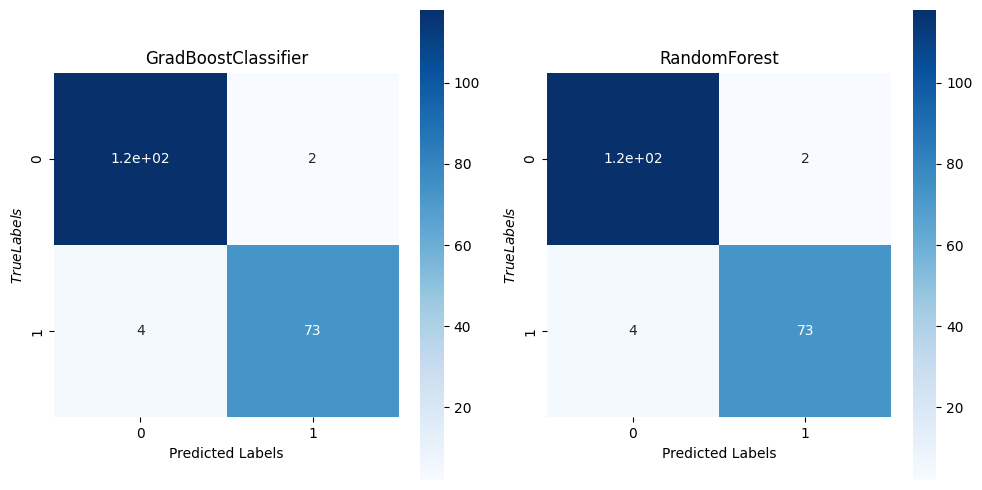

In [111]:
evaluation_dict = cm_plotter(models_dict, X_test2, y_test2,)

That shows a great performance of our models.